# Miriade DataGame

In [273]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [263]:
# settaggio random seed che consente risultati comparabili per le prove
RANDOM_STATE = 42

In [264]:
train = pd.read_csv("/home/null/PycharmProjects/Miriade/data/raw_data/dataset_stima.csv")
test = pd.read_csv("/home/null/PycharmProjects/Miriade/data/raw_data/dataset_previsione.csv")

In [265]:
df = train.groupby('PUBBLICITA')['ID'].nunique()
y = pd.Series(df)
x = np.sort(train['PUBBLICITA'].unique())[:-1]

<Container object of 815 artists>

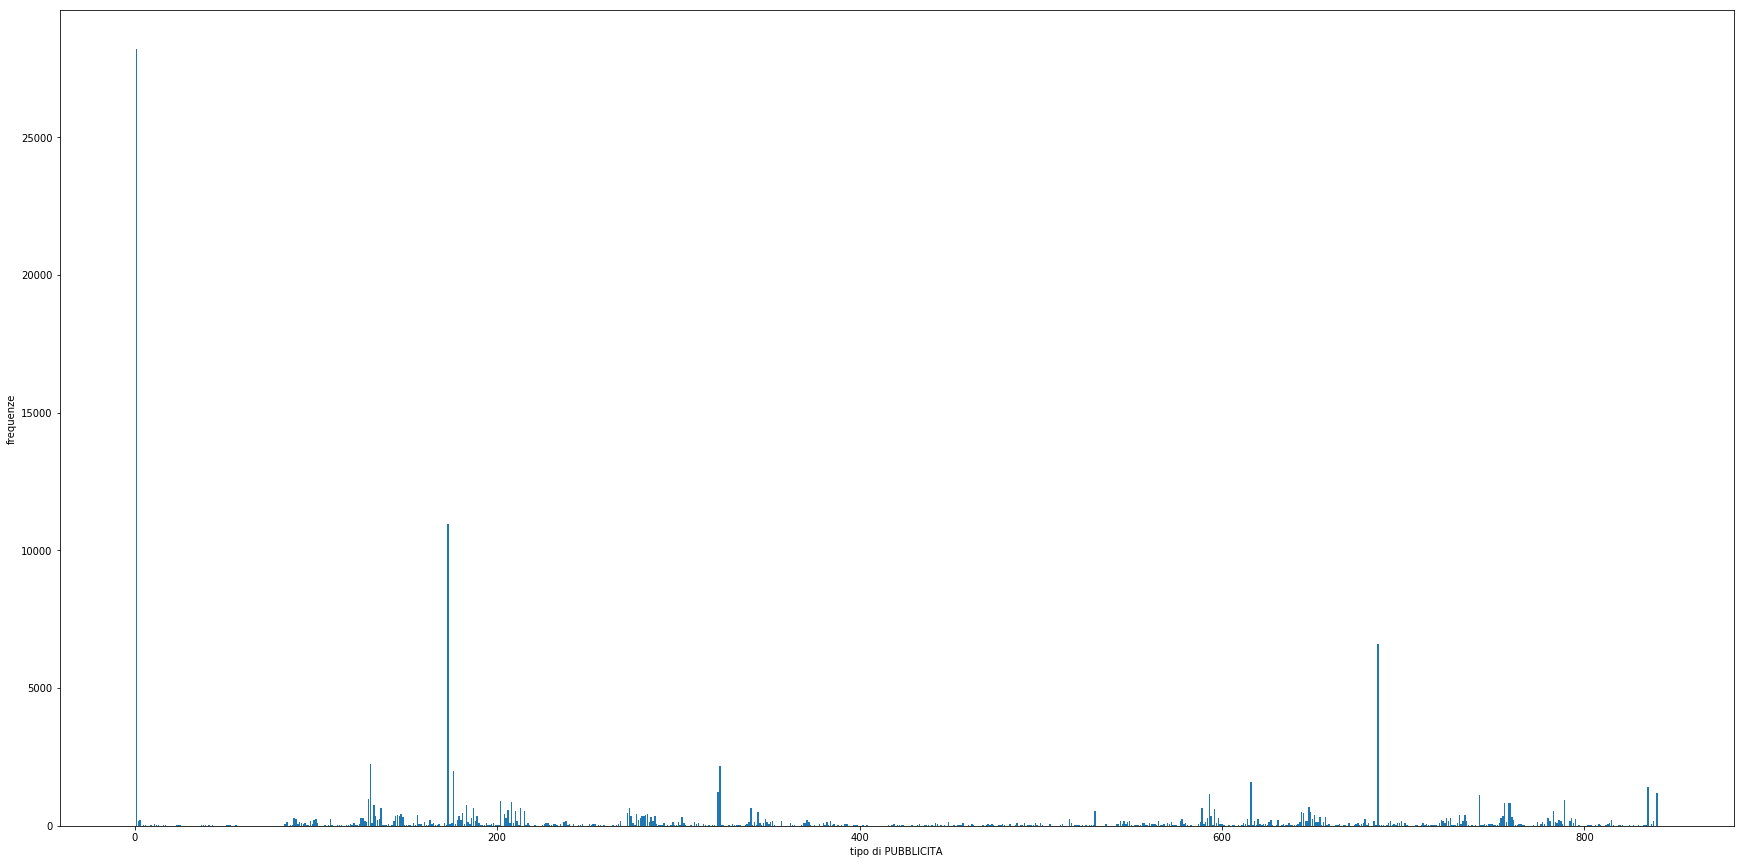

In [266]:
plt.figure(figsize=(30,15))
plt.xlabel('tipo di PUBBLICITA')
plt.ylabel('frequenze')
plt.bar(x, y)

In [267]:
# imputazione valore modale alla var PUBBLICITA
moda_TIPO_PUBBLICITA = stats.mode(train['PUBBLICITA'][train['PUBBLICITA']!=pd.NaT])
train['PUBBLICITA'] = train['PUBBLICITA'].fillna(int(moda_TIPO_PUBBLICITA.mode))
train['PUBBLICITA'].isnull().sum()

0

In [268]:
# drop delle osservazioni con valori negativi della variabile NUMERO_CLICK_SITO
train.drop(train[train.NUMERO_CLICK_SITO < 0].index, inplace=True)

# drop outlier della var. NUMERO_CLICK_SITO
train.drop(train[train['NUMERO_CLICK_SITO'] > 11000].index, inplace=True)

#train['NUMERO_CLICK_SITO'].quantile(.9999)

In [269]:
# correzione anno 3000
anno_3000 = train['FINE_PUBBLICITA'].str.match('3000')
max_anno = np.max(train['FINE_PUBBLICITA'][[not i for i in anno_3000]])
train.loc[anno_3000, 'FINE_PUBBLICITA'] = max_anno

In [274]:
[(x,y) for x,y in zip(train.columns, range(len(train.columns)))]

[('PUBBLICITA', 0),
 ('INIZIO_PUBBLICITA', 1),
 ('FINE_PUBBLICITA', 2),
 ('MACRO_TIPO_PUBBLICITA', 3),
 ('FASCIA_ORARIA', 4),
 ('FASCIA_TEMPISTICA', 5),
 ('TIPO_PUBBLICITA', 6),
 ('DATA', 7),
 ('CODICE_GIOCO', 8),
 ('RILANCIO_PUBBLICITA', 9),
 ('SESSIONE', 10),
 ('NUMERO_CLICK_SITO', 11),
 ('OFFERTA_PROMOZIONALE', 12),
 ('MACRO_CATEGORIA_GIOCO', 13),
 ('MICRO_CATEGORIA_GIOCO', 14),
 ('AREA_CLICK', 15),
 ('NUMERO_PUBBLICITA_CONCORRENTI', 16),
 ('ID', 17),
 ('CLICK_PER_AREA', 18)]

In [270]:
#train['TIPO_PUBBLICITA'] = train['TIPO_PUBBLICITA'].astype('int').astype('category')

train['PUBBLICITA'] = train['PUBBLICITA'].astype('int').astype('category')
train['MACRO_TIPO_PUBBLICITA'] = train['MACRO_TIPO_PUBBLICITA'].astype('category')
train['FASCIA_ORARIA'] = train['FASCIA_ORARIA'].astype('category')
train['FASCIA_TEMPISTICA'] = train['FASCIA_TEMPISTICA'].astype('category')
train['CODICE_GIOCO'] = train['CODICE_GIOCO'].astype('category')
train['RILANCIO_PUBBLICITA'] = train['RILANCIO_PUBBLICITA'].astype('int')
train['SESSIONE'] = train['SESSIONE'].astype('int').astype('category')
train['MACRO_CATEGORIA_GIOCO'] = train['MACRO_CATEGORIA_GIOCO'].astype('category')
train['MICRO_CATEGORIA_GIOCO'] = train['MICRO_CATEGORIA_GIOCO'].astype('category')
train['AREA_CLICK'] = train['AREA_CLICK'].astype('int')
train['ID'] = train['ID'].astype('int').astype('category')

train['INIZIO_PUBBLICITA'] = pd.to_datetime(train['INIZIO_PUBBLICITA'], format='%Y-%m-%d')
train['FINE_PUBBLICITA'] = pd.to_datetime(train['FINE_PUBBLICITA'], format='%Y-%m-%d')
train['DATA'] = pd.to_datetime(train['DATA'], format='%Y-%m-%d')

test['PUBBLICITA'] = test['PUBBLICITA'].astype('int').astype('category')
test['MACRO_TIPO_PUBBLICITA'] = test['MACRO_TIPO_PUBBLICITA'].astype('category')
test['FASCIA_ORARIA'] = test['FASCIA_ORARIA'].astype('category')
test['FASCIA_TEMPISTICA'] = test['FASCIA_TEMPISTICA'].astype('category')
test['CODICE_GIOCO'] = test['CODICE_GIOCO'].astype('category')
test['RILANCIO_PUBBLICITA'] = test['RILANCIO_PUBBLICITA'].astype('int')
test['SESSIONE'] = test['SESSIONE'].astype('int').astype('category')
test['MACRO_CATEGORIA_GIOCO'] = test['MACRO_CATEGORIA_GIOCO'].astype('category')
test['MICRO_CATEGORIA_GIOCO'] = test['MICRO_CATEGORIA_GIOCO'].astype('category')
test['AREA_CLICK'] = test['AREA_CLICK'].astype('int')
test['ID'] = test['ID'].astype('int').astype('category')

In [178]:
# aggiustamento variabili INIZIO_PUBBLICTA e FINE_PUBBLICITA
flag = 0
for i, _ in train.iterrows():
    if train['INIZIO_PUBBLICITA'][i] > train['FINE_PUBBLICITA'][i]:
        flag = train['INIZIO_PUBBLICITA'][i]
        train.loc[i, 'INIZIO_PUBBLICITA'] = train['FINE_PUBBLICITA'][i]
        train.loc[i, 'FINE_PUBBLICITA'] = flag

In [179]:
# aggiustamento var DATA per rispettare i limiti delle var INIZIO_PUBBLICITA e FINE_PUBBLICITA
a = 0
for i, _ in train.iterrows():
    
    if train['DATA'][i]<train['INIZIO_PUBBLICITA'][i]:
        flag_inizio = train['INIZIO_PUBBLICITA'][i]
        train.loc[i, 'INIZIO_PUBBLICITA'] = train['DATA'][i]
        train.loc[i, 'DATA'] = flag_inizio
        
    if train['DATA'][i]>train['FINE_PUBBLICITA'][i]:
        flag_fine = train['FINE_PUBBLICITA'][i]
        train.loc[i, 'FINE_PUBBLICITA'] = train['DATA'][i]
        train.loc[i, 'DATA'] = flag_fine

In [180]:
# verifica dell'aggiustamento
for i, _ in train.iterrows():
    if (train['DATA'][i]<train['INIZIO_PUBBLICITA'][i] and train['DATA'][i]>train['FINE_PUBBLICITA'][i]):
        print(i)

In [181]:
# controllo var DATA: contiene solo valori dell'anno 2016
for i, _ in train.iterrows():
    if pd.Timestamp("2015-12-31") > train['DATA'][100] > pd.Timestamp("2017-01-01"):
        print(i)

In [182]:
# vettore giorni 2016
days_2016 = pd.date_range("2016-01-01", periods=366, freq='d')

# vettore dummy domenica
dummy = [0, 0, 1]
dummy.extend([0, 0, 0, 0, 0, 0, 1]*52)
dummy_domenica = dummy[:-1]

#aggiungo primo dell'anno e vigilia di natale
dummy_domenica[0] = 1
dummy_domenica[-8] = 1

# vettore domenica 2016
domenica_2016 = []
for i in range(len(dummy_domenica)):
    if dummy_domenica[i]:
        domenica_2016.append(days_2016[i])

In [183]:
# aggiungo NEW_DOMENICA al training e al test set
train['NEW_DOMENICA'] = 0
for i, _ in train.iterrows():
    if train['DATA'][i] in domenica_2016:
        train.loc[i, 'NEW_DOMENICA'] = 1

test['NEW_DOMENICA'] = 0
for i, _ in test.iterrows():
    if test['DATA'][i] in domenica_2016:
        test.loc[i, 'NEW_DOMENICA'] = 1

In [186]:
# modifico il tipo perchè categorica
train['NEW_DOMENICA'] = train['NEW_DOMENICA'].astype('category')
test['NEW_DOMENICA'] = test['NEW_DOMENICA'].astype('category')

In [187]:
X = train.iloc[:, [3, 4, 5, 8, 9, 10, 12, 13, 14, 15, 16, 18]]  # 0, 6, 7 have missing data; 1, 2, 4 date vars; 17 is ID
y = train.iloc[:, 11]

X_test = test.iloc[:, [3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 17]]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85, test_size=0.15)

NameError: name 'X' is not defined

In [188]:
rf_model = RandomForestRegressor(n_estimators=10)
rf_model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [82]:
y_pred_validation = rf_model.predict(X_validation)

In [83]:
def score_fun(y_pred, y_true):
    return np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y_true + 1))**2))

0.04255784250905376

In [ ]:
score_validation = score_fun(y_pred_validation, y_validation)

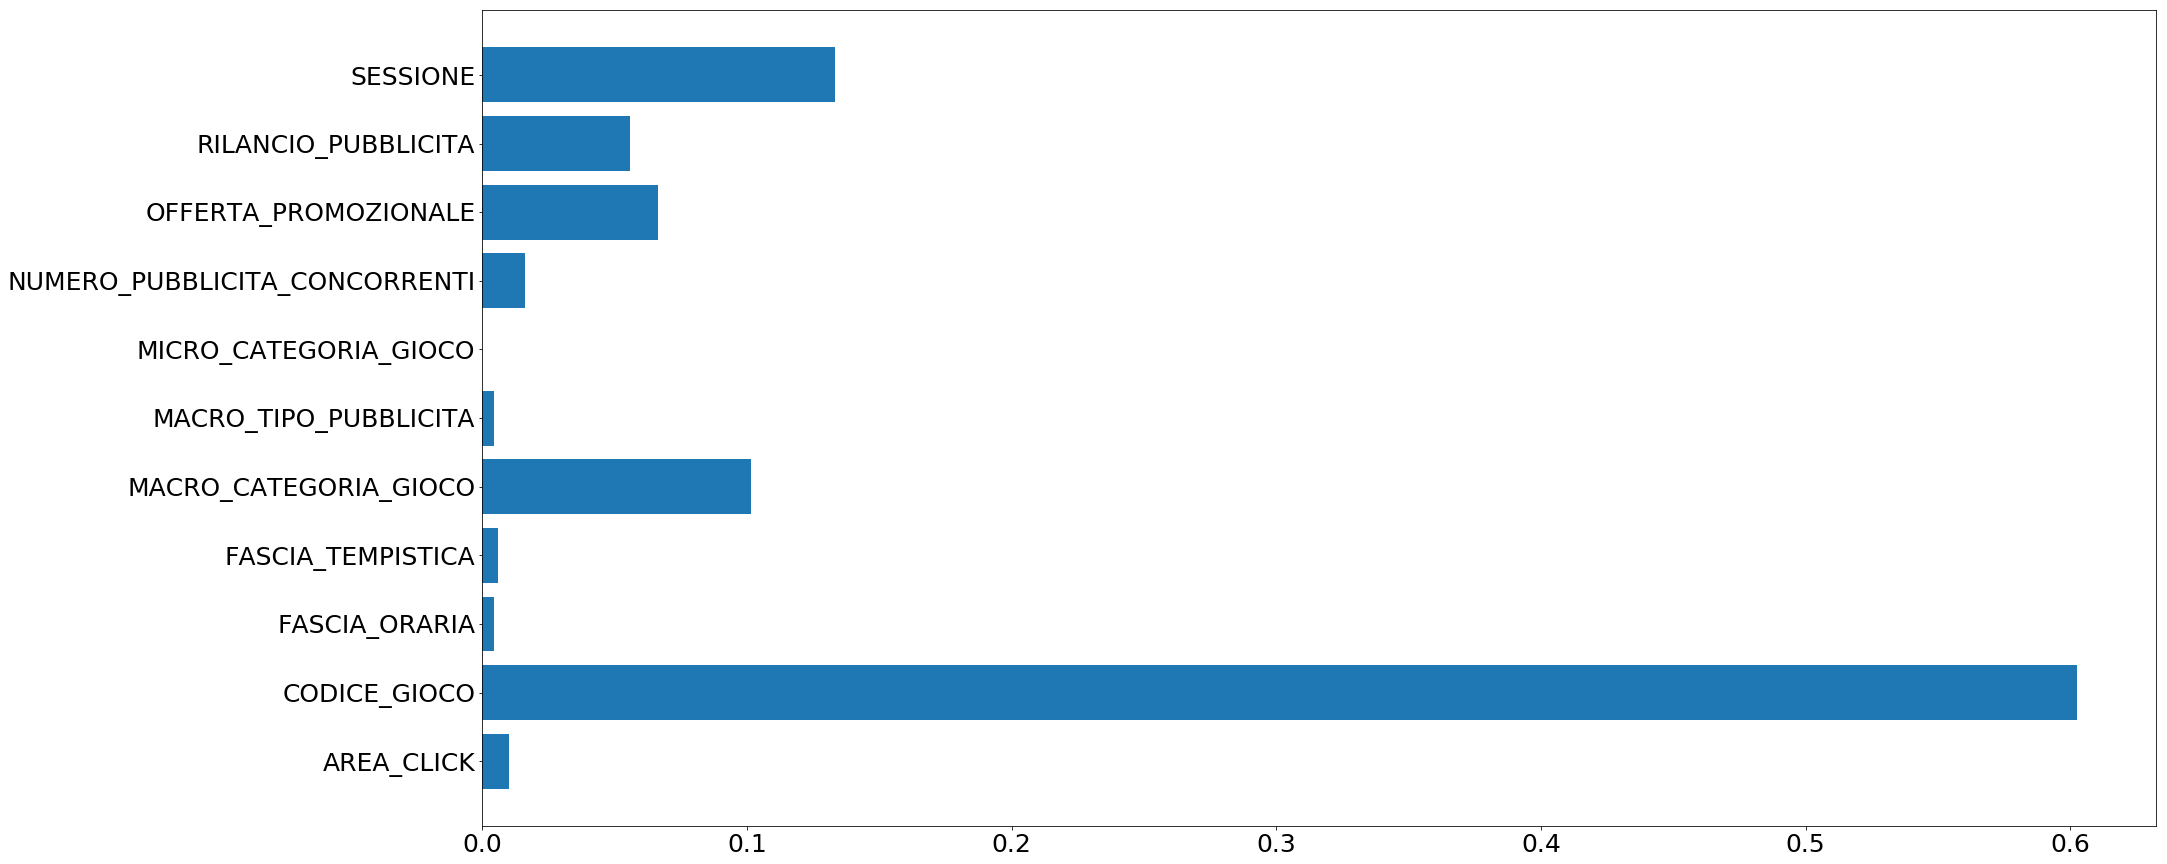

In [84]:
var_label, var_importance = X.columns, rf_model.feature_importances_

plt.figure(figsize=(30,15))
plt.barh(var_label, var_importance)
plt.tick_params(labelsize=25)